In [192]:
%%capture
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras
print(keras.__version__) # 2.0.0
from math import nan
from tensorflow.keras.callbacks import ModelCheckpoint

"""!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF""" # keras_contrib already included in keras if not it will install from git

In [11]:
def get_path(*args):
    spec_path = os.sep.join(args)
    return os.path.join(os.getcwd(), spec_path)
    

In [45]:
data = dict()
data["sentence_id"] = list()
data["tag"] = list()
data["word"] = list()

word_arr = data["word"]

word_arr.append("bla")
data

{'sentence_id': [], 'tag': [], 'word': ['bla']}

In [51]:
# read file and create data frame from it

file_path = get_path("resource", "TWNERTC_TC_Coarse Grained NER_DomainIndependent_NoiseReduction.DUMP") 

f = open(file_path, "r", encoding="UTF-8")

line_count = 0

data = dict()
data["sentence_id"] = list()
data["tag"] = list()
data["word"] = list()

sentence_id_arr = data["sentence_id"]
tag_arr = data["tag"]
word_arr = data["word"]


for line in f.readlines():
    line_count += 1
    # each line seperated by ht (horizontal tabs)
    splitted = line.split("\t")
    
    tag_split = splitted[1].split(" ")
    word_split = splitted[2].split(" ")
    
    for tag, word in zip(tag_split, word_split):
        word = word.strip()
        if word[len(word)-1] == "\n":
            word = word[:-1]
        
        sentence_id_arr.append(line_count)
        tag_arr.append(tag)
        word_arr.append(word)

df = pd.DataFrame(data, columns=["sentence_id", "tag", "word"])

df.head()



,sentence_id,tag,word
0,1,B-PERSON,Corina
1,1,I-PERSON,Casanova
2,1,O,","
3,1,B-LOCATION,İsviçre
4,1,O,Federal


In [63]:
df.shape[0]

8969975

In [56]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [57]:
getter = SentenceGetter(df)

In [58]:
sentences = getter.sentences

In [70]:
print(f"Number of sentences in data set {len(sentences)}")

Number of sentences in data set 532629


In [69]:
sentences[10]

[('Denton', 'B-LOCATION'),
 (',', 'O'),
 ('Amerika', 'B-LOCATION'),
 ('Birleşik', 'I-LOCATION'),
 ("Devletleri'nde", 'I-LOCATION'),
 ('Teksas', 'B-LOCATION'),
 ('eyaletinin', 'O'),
 ('Denton', 'B-LOCATION'),
 ('bölgesindeki', 'O'),
 ('bir', 'O'),
 ('şehirdir', 'O'),
 ('.', 'O')]

In [71]:
# check length of longest sentence 
max_len = max([len(s) for s in sentences])
print ('Maximum sequence length:', max_len)

Maximum sequence length: 50


In [72]:
# visualize the length of sentences in data
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

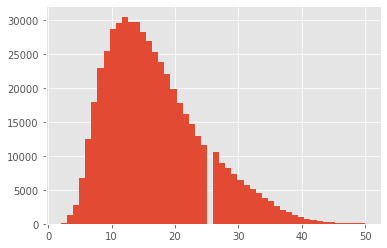

In [74]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [76]:
# create set of unique words and add ENDPAD as last element
words = list(set(df["word"].values))
words.append("ENDPAD")

In [77]:
n_words = len(words) 
n_words

532053

In [81]:
tags = list(set(df["tag"].values))
tags

['O',
 'B-LOCATION',
 'I-MISC',
 'B-MISC',
 'I-LOCATION',
 'I-ORGANIZATION',
 'B-PERSON',
 'I-PERSON',
 'B-ORGANIZATION']

In [128]:
n_tags = len(tags); n_tags

9

In [85]:
# creating index dictionaries for words and tags
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [91]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=50, sequences=X, padding="post",value=n_words - 1)

In [213]:
# We append "O" tags end of each sentence that smaller than 50.
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=50, sequences=y_idx, padding="post", value=tag2idx["O"])

In [105]:
print(y_idx[2])

[6, 7, 0, 3, 0, 0]


In [196]:
len(y) # it should be equal longest sentence length

532629

In [201]:
"""from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]"""

MemoryError: Unable to allocate 8.04 GiB for an array with shape (532629, 50, 9, 9) and data type float32

In [214]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [184]:
from tensorflow.python.keras.models import Model, Input
from tensorflow.python.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import tensorflow.keras as k
from tf2crf import CRF, ModelWithCRFLoss
print(k.__version__)

2.5.0


In [185]:
input = Input(shape=(50,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=50)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

C:\Program Files\Python39\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


In [186]:
model = Model(input, out)
model = ModelWithCRFLoss(model, sparse_target=True)

In [188]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam)

In [198]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 50, 300)           159615900 
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 50, 600)           1442400   
_________________________________________________________________
lstm_47 (LSTM)               (None, 50, 600)           2882400   
_________________________________________________________________
time_distributed_13 (TimeDis (None, 50, 9)             5409      
_________________________________________________________________
crf_2 (CRF)                  ((None, 50), (None, 50, 9 189       
Total params: 163,946,298
Trainable params: 163,946,298
Non-trainable params: 0
_____________________________________________

In [190]:
filepath="ner-bi-lstm-td-model-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [210]:
print(len(X_train))
print(len(y_train))

426103
426103


In [215]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=50, epochs=20, validation_split=0.2, verbose=1)
model.save("Bi-LSTM_CRF_NER_model.h5")

Epoch 1/20


ValueError: in user code:

    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:799 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:530 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:630 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\utils.py:75 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['embedding_24/embeddings:0', 'bidirectional_24/forward_lstm_46/lstm_cell_95/kernel:0', 'bidirectional_24/forward_lstm_46/lstm_cell_95/recurrent_kernel:0', 'bidirectional_24/forward_lstm_46/lstm_cell_95/bias:0', 'bidirectional_24/backward_lstm_46/lstm_cell_96/kernel:0', 'bidirectional_24/backward_lstm_46/lstm_cell_96/recurrent_kernel:0', 'bidirectional_24/backward_lstm_46/lstm_cell_96/bias:0', 'lstm_47/lstm_cell_97/kernel:0', 'lstm_47/lstm_cell_97/recurrent_kernel:0', 'lstm_47/lstm_cell_97/bias:0', 'time_distributed_13/kernel:0', 'time_distributed_13/bias:0', 'crf_2/transitions:0', 'crf_2/left_boundary:0', 'crf_2/right_boundary:0', 'crf_2/dense/kernel:0', 'crf_2/dense/bias:0'].
